# [7.1. Deep Convolutional Neural Networks (AlexNet)](https://d2l.ai/chapter_convolutional-modern/alexnet.html#alexnet)


Paper : [ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky+2012)](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

#### Deep Networks learn features **hierarchically**. 
- In the case of an image, the lowest layers might come to detect edges, colors, and textures.
- Higher layers in the network might build upon these representations to represent larger structures, like eyes, noses, blades of grass...
- Even higher layers might represent whole objects like people, airplanes, dogs, or frisbees...
    
## AlexNet

- AlexNet is a 8-layer network. (When counting the number of layers of a deep neural network, we only consider the layers that have learnable parameters. So pooling layers are not counted here.)

- The architectures of **AlexNet** and **LeNet** are very similar. <br>
  Here the textbook adopts a slightly streamlined version of AlexNet.

<img src='./images/fig_7.1.2.png' width='400'/>

- AlexNet used the **ReLU** as its activation function, instead of the **sigmoid** as in LeNet.

## Implement AlexNet in PyTorch

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### architecture

- The total number of trainable parameters is order of $10^3$ more in AlexNet compared with LeNet.

In [2]:
net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 46764746


In [3]:
# output dimension of each layer
X = torch.randn(1, 1, 224, 224).to(device)

print('Input shape:\t', X.shape)

for layer in net:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Input shape:	 torch.Size([1, 1, 224, 224])
Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Load FashionMNIST dataset and apply data transforms


- Use ``torchvision.transforms.Resize`` to resize the FashionMNIST from 28x28 to 224x224, in order to match with the AlexNet architecture. 


- ``torchvision.transforms.RandomHorizontalFlip`` : randomly horizantally flip the images for each mini-batch draw durning training.

In [4]:
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [5]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


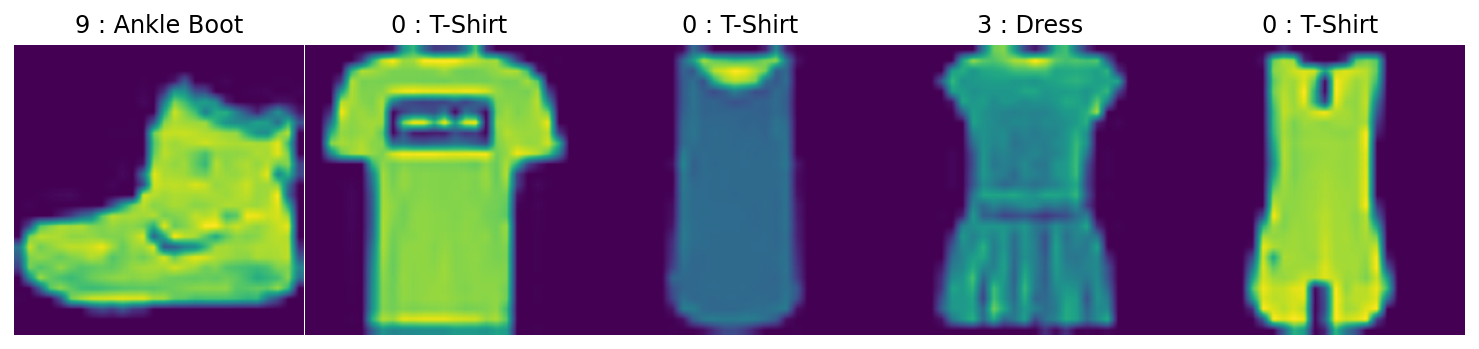

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i in range(5):
    image, label = fmnist_train.__getitem__(i)
    axes[i].imshow(image.squeeze().numpy())
    axes[i].set_title(f'{label} : {labels_map[label]}')
    axes[i].axis('off')

In [7]:
batch_size = 128

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

In [8]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([128, 1, 224, 224])

### Loss

In [9]:
criterion = nn.CrossEntropyLoss()

### Optimization Function

In [10]:
learning_rate = 0.1

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

### Trainin Loop

In [11]:
def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [12]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)

>>> End epoch 1, train accuracy = 13.91%, train avgLoss = 2.2863
>>>              valid accuracy = 10.95%, valid avgLoss = 2.2195
>>> End epoch 2, train accuracy = 61.49%, train avgLoss = 1.0155
>>>              valid accuracy = 76.54%, valid avgLoss = 0.6089
>>> End epoch 3, train accuracy = 80.23%, train avgLoss = 0.5207
>>>              valid accuracy = 83.30%, valid avgLoss = 0.4454
>>> End epoch 4, train accuracy = 84.37%, train avgLoss = 0.4202
>>>              valid accuracy = 84.10%, valid avgLoss = 0.4101
>>> End epoch 5, train accuracy = 86.62%, train avgLoss = 0.3612
>>>              valid accuracy = 86.80%, valid avgLoss = 0.3465
>>> End epoch 6, train accuracy = 87.78%, train avgLoss = 0.3258
>>>              valid accuracy = 87.62%, valid avgLoss = 0.3248
>>> End epoch 7, train accuracy = 88.60%, train avgLoss = 0.2991
>>>              valid accuracy = 88.79%, valid avgLoss = 0.3047
>>> End epoch 8, train accuracy = 89.50%, train avgLoss = 0.2813
>>>              valid ac

## Plot

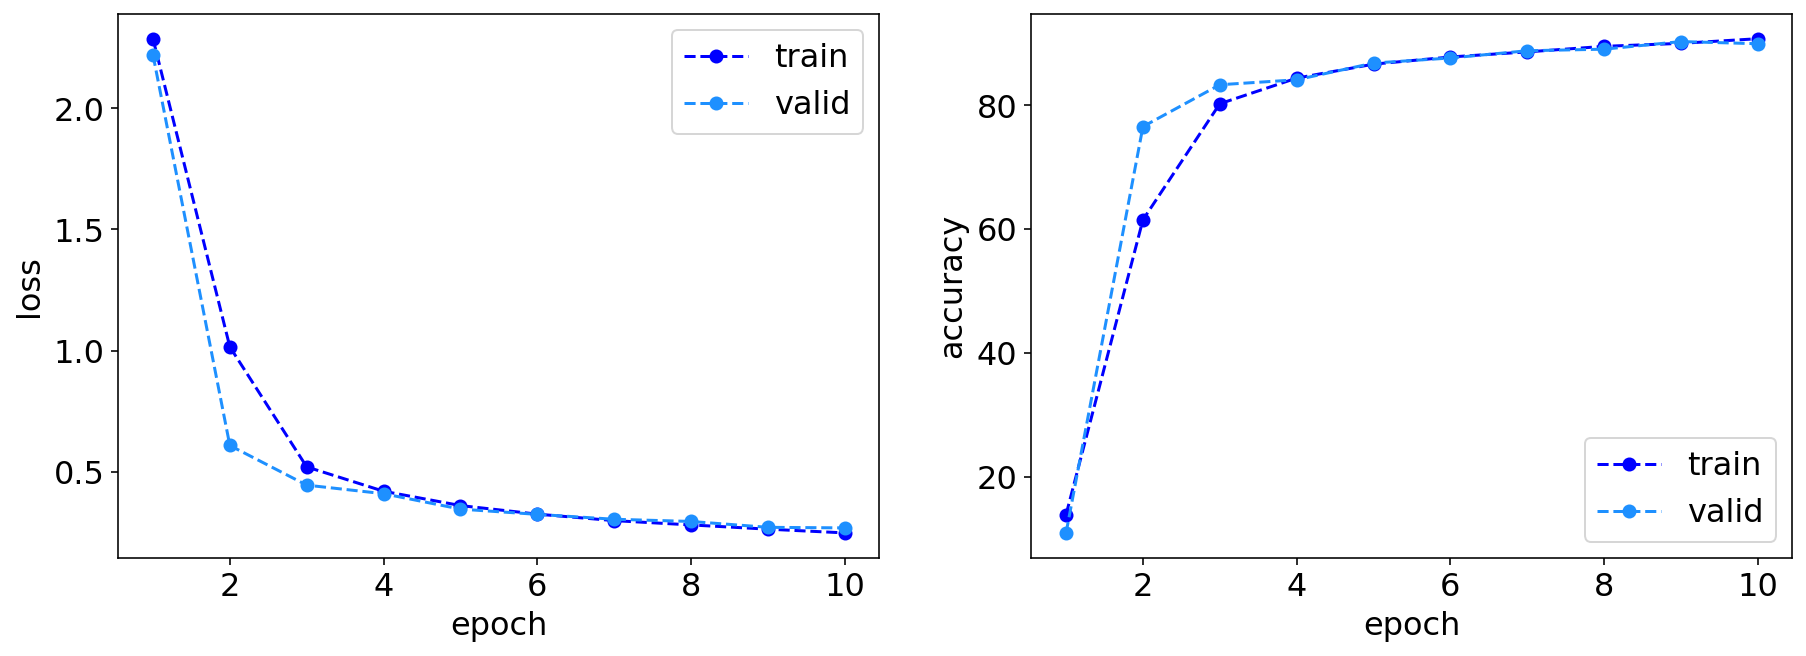

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')